In [13]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
import re

In [2]:
# Load data
df = pd.read_csv('../data/product_df.csv')
df = df[['Star Rating', 'Comment']]

In [3]:
# Kiểm tra và loại bỏ giá trị khuyết thiếu
print(df.isnull().sum())
df = df.dropna(subset=['Comment'])

Star Rating    0
Comment        0
dtype: int64


In [4]:
# Kiểm tra và loại bỏ dữ liệu trùng lặp
duplicate_comments = df[df.duplicated(['Comment'])]
print("Các dòng dữ liệu trùng lặp trong cột 'Comment':")
print(duplicate_comments)
df = df.drop_duplicates(['Comment'])
print("Shape after dropping duplicates:", df.shape)

Các dòng dữ liệu trùng lặp trong cột 'Comment':
      Star Rating                                   Comment
48              4                                   Rất tốt
76              5                                    Rất ok
107             2                             pin tụt nhanh
135             5                              sản phẩm tốt
173             2                             hao pin nhanh
177             5                              sản phẩm tốt
181             5                                    Rất ok
183             5                              sản phẩm tốt
192             5                               sản phẩm ok
205             5                               máy dùng ok
225             4                                       Tốt
227             5                               sản phẩm ok
237             5                               máy dùng ok
250             5                              sản phẩm tốt
426             4                              máy d

In [5]:
# Chuẩn hóa và làm sạch văn bản
def remove_special_characters(text):
    # Loại bỏ các ký tự đặc biệt, giữ lại chữ cái, số, và các dấu câu
    return re.sub(r'[^a-zA-ZÀ-ỹà-ỹ0-9\s.,!?]', '', text)

def to_lowercase(text):
    # Chuyển đổi văn bản về chữ thường
    return text.lower()

def add_space_around_punctuation(text):
    # Tạo khoảng cách giữa từ và dấu câu
    text = re.sub(r'([.,!?])', r' \1 ', text)
    text = re.sub(r'\s{2,}', ' ', text) # Loại bỏ khoảng trắng thừa
    return text

def normalize_text(text):
    text = remove_special_characters(text)
    text = to_lowercase(text)
    text = add_space_around_punctuation(text)
    return text

df['Comment'] = df['Comment'].apply(normalize_text)
print(df.head())

   Star Rating                                            Comment
0            4                      điện thoại này dùng rất thích
1            4                               sử dụng thấy cũng ok
2            2                     bảo hành ít quá , chỉ 12 tháng
3            5                            sản phẩm mượt , chạy êm
4            3  cho mình hỏi muốn khởi động lại máy hay tắt ng...


In [6]:
# # Loại bỏ stopwords
# with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
#     stopwords = f.readlines()
# stopwords = [word.strip() for word in stopwords]

# def remove_stopwords(comment):
#     words = comment.split()
#     cleaned_words = [word for word in words if word.lower() not in stopwords]
#     return ' '.join(cleaned_words)

# df['Comment'] = df['Comment'].apply(remove_stopwords)
# print(df.head())

In [7]:
# Tokenization và xây dụng vocab
nltk.download('punkt')

def tokenize_and_build_vocab(comment):
    tokens = word_tokenize(comment)
    return tokens

df['Tokenized_Comment'] = df['Comment'].apply(tokenize_and_build_vocab)

all_tokens = [token for sublist in df['Tokenized_Comment'] for token in sublist]
vocab = FreqDist(all_tokens)

print("Tổng số từ duy nhất:", len(vocab))
print("Các từ và tần suất xuất hiện:")
for word, frequency in vocab.most_common(10):  # Print only top 10 words
    print(f"{word}: {frequency}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vuhamy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tổng số từ duy nhất: 1751
Các từ và tần suất xuất hiện:
.: 1684
,: 1508
máy: 775
không: 674
dùng: 595
mua: 477
pin: 454
được: 422
rất: 409
tốt: 352


In [14]:
# Word2Vec encoding
model_path = 'word2vec_vi_words_100dims.txt'
w2v_model = KeyedVectors.load_word2vec_format(model_path)

# Encode comments bằng mô hình Word2Vec
def encode_comment(tokens):
    vectors = []
    for token in tokens:
        if token in w2v_model:
            vectors.append(w2v_model[token])
        else:
            vectors.append(np.random.uniform(-0.25, 0.25, w2v_model.vector_size))  # Sử dụng vector ngẫu nhiên thay vì vector 0
    return vectors

# Apply encoding function
df['Encoded_Comment'] = df['Tokenized_Comment'].apply(encode_comment)

# Display the result
print(df[['Tokenized_Comment', 'Encoded_Comment']].head())

                                   Tokenized_Comment  \
0               [điện, thoại, này, dùng, rất, thích]   
1                         [sử, dụng, thấy, cũng, ok]   
2            [bảo, hành, ít, quá, ,, chỉ, 12, tháng]   
3                     [sản, phẩm, mượt, ,, chạy, êm]   
4  [cho, mình, hỏi, muốn, khởi, động, lại, máy, h...   

                                     Encoded_Comment  
0  [[-0.08860478, -0.02230161, -0.012114897, -0.0...  
1  [[0.0056972285, -0.13212787, -0.048384234, 0.0...  
2  [[-0.07248304, 0.007964071, -0.092036, -0.0315...  
3  [[-0.19052374, 0.016779905, 0.04856115, 0.1014...  
4  [[0.025698958, 0.13460597, 0.12504221, 0.02369...  


In [15]:
def label_sentiment(rating):
    if rating in [1, 2]:
        return 'tiêu cực'
    elif rating == 3:
        return 'trung tính'
    elif rating in [4, 5]:
        return 'tích cực'
    else:
        return 'không rõ'  # Nếu có xếp hạng nằm ngoài khoảng 1-5

# Gắn nhãn cảm xúc cho mỗi đánh giá
df['Sentiment'] = df['Star Rating'].apply(label_sentiment)

# Hiển thị 5 hàng đầu tiên của dataframe với cột sentiment mới
print(df.head())

   Star Rating                                            Comment  \
0            4                      điện thoại này dùng rất thích   
1            4                               sử dụng thấy cũng ok   
2            2                     bảo hành ít quá , chỉ 12 tháng   
3            5                            sản phẩm mượt , chạy êm   
4            3  cho mình hỏi muốn khởi động lại máy hay tắt ng...   

                                   Tokenized_Comment  \
0               [điện, thoại, này, dùng, rất, thích]   
1                         [sử, dụng, thấy, cũng, ok]   
2            [bảo, hành, ít, quá, ,, chỉ, 12, tháng]   
3                     [sản, phẩm, mượt, ,, chạy, êm]   
4  [cho, mình, hỏi, muốn, khởi, động, lại, máy, h...   

                                     Encoded_Comment   Sentiment  
0  [[-0.08860478, -0.02230161, -0.012114897, -0.0...    tích cực  
1  [[0.0056972285, -0.13212787, -0.048384234, 0.0...    tích cực  
2  [[-0.07248304, 0.007964071, -0.092036, -0.03

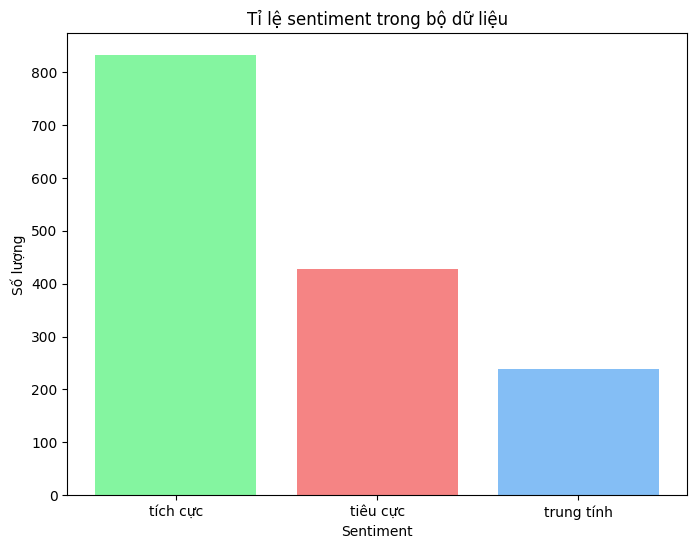

In [ ]:
import matplotlib.pyplot as plt
#Đếm số lượng sentiment
label_counts = df['Sentiment'].value_counts()

# Lấy các nhãn và số lượng tương ứng
labels = label_counts.index.tolist()
sizes = label_counts.values.tolist()

# Chọn màu sắc hài hòa
colors = ['#84f5a0', '#f58484', '#84bef5']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color= colors)
plt.xlabel('Sentiment')
plt.ylabel('Số lượng')
plt.title('Tỉ lệ sentiment trong bộ dữ liệu')
plt.show()

In [ ]:
df.to_csv('../data/processed_data.csv', index=False)